# Illustrating Model Properties

Roman Ludwig [](https://orcid.org/0000-0001-9434-328X)  
Yoel Perez Haas  
Jan Unkelbach [](https://orcid.org/0000-0002-4275-990X)

# Diagnose Time Prior and Evolution of Midline Extension

First, we illustrate how the prior distribution over diagnose times and the conditional distribution of having developed a tumor that crosses the mid-sagittal line *given* a diagnosis time evolve together.

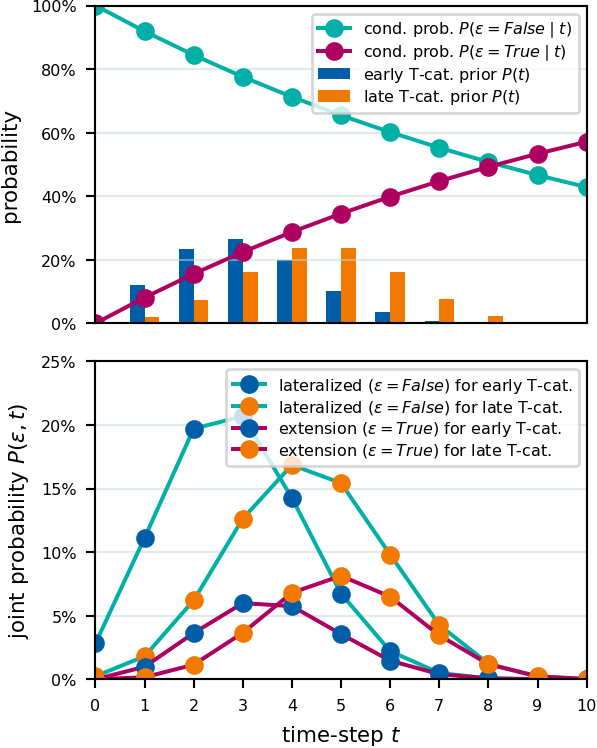

In [1]:
#| label: fig-model-midext-evo
#| fig-cap: "The top panel shows the prior probability to get diagnosed at time-step $t$ for early and late T-category tumors as bars. Also in the top panel, we plot the conditional probability of the tumor's midline extension ($\epsilon=\texttt{True}$), given the time-step $t$ as a line plot. In the bottom panel, we show the joint probability of getting diagnosed in time-step $t$ *and* having a tumor that crosses the midline."
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import ticker
from lyscripts.plot.utils import COLORS
from scripts import shared, paths

model = shared.get_model("simple", load_samples=True)

t = np.linspace(0, 10, 11)
p_midline = {
  "lateralized": (1 - model.midext_prob)**t,
  "extension": 1 - (1 - model.midext_prob)**t,
}
dist = {
  "early": model.get_distribution("early").pmf,
  "late": model.get_distribution("late").pmf,
}
p_colors = {"lateralized": COLORS["green"], "extension": COLORS["red"]}
t_colors = {"early": COLORS["blue"], "late": COLORS["orange"]}
markers = {}

nrows, ncols = 2, 1
plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  width=17/2,
))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
w = 0.3

for label, p in p_midline.items():
  axes[0].plot(
    t, p_midline[label], "o-",
    label=f"cond. prob. $P(\epsilon={label=='extension'} \mid t)$",
    color=p_colors[label],
  )
  for i, t_stage in enumerate(["early", "late"]):
    if label == "lateralized":
      axes[0].bar(
        t + i*w - w/2, dist[t_stage],
        color=t_colors[t_stage],
        width=w,
        label=f"{t_stage} T-cat. prior $P(t)$",
      )
    axes[1].plot(
      t, p * dist[t_stage], "o-",
      c=p_colors[label],
      mfc=t_colors[t_stage],
      mec=t_colors[t_stage],
      label=f"{label} ($\epsilon={label=='extension'}$) for {t_stage} T-cat.",
    )

axes[0].set_ylim(0., 1.)
axes[0].tick_params(bottom=False, labelbottom=False)
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[0].set_ylabel("probability")
axes[0].grid(axis="y", color=COLORS["gray"], alpha=0.5)

axes[0].legend(labelspacing=0.2)

axes[1].set_xlim(min(t), max(t))
axes[1].set_xticks(t)
axes[1].set_xlabel("time-step $t$")

axes[1].set_ylim(0., 0.25)
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[1].set_ylabel("joint probability $P(\epsilon, t)$")
axes[1].grid(axis="y", color=COLORS["gray"], alpha=0.5)

axes[1].legend(labelspacing=0.2)

plt.savefig(paths.figure_dir / "fig-model-midext-evo.png", dpi=400)
plt.show()

# Sampling History

For bookeeping, we also show how different quantities evolve during the burnin of the sampling. For example, the ratio of proposed samples that were accepted or the autocorrelation time.

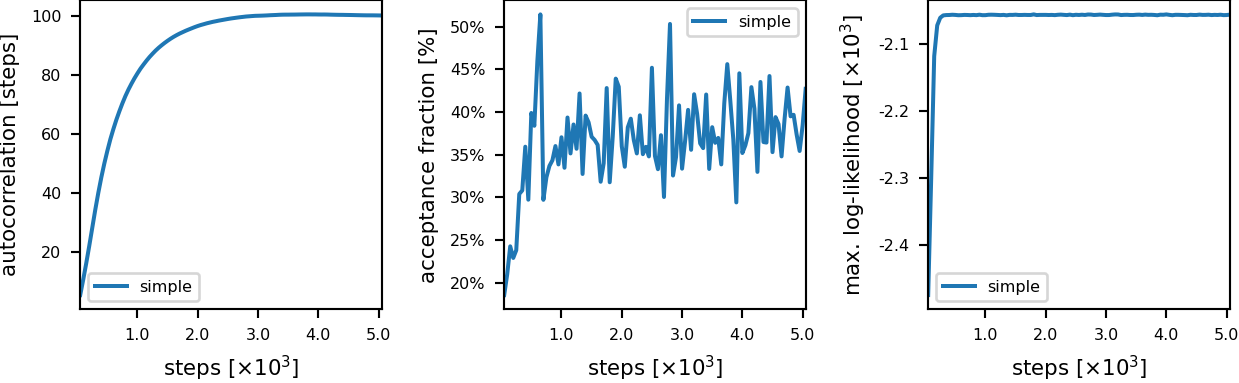

In [2]:
#| echo: false
#| label: fig-model-burnin-history
#| fig-cap: Monitoring quantities during the burn-in phase of the parameter sampling.
from collections import namedtuple
import pandas as pd
from scripts import shared, paths

def custom(x, pos):
  return "{:.1f}".format(x/1000)

nrows, ncols = 1, 3
label_map = {
  "acor_times": "autocorrelation [steps]",
  "accept_fracs": "acceptance fraction [%]",
  "max_log_probs": r"max. log-likelihood [$\times 10^3$]",
}

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=1.,
  width=17,
))

fig, axes = plt.subplots(
  nrows=nrows,
  ncols=ncols,
  sharex=True,
)

for model in ["simple"]:
  history = pd.read_csv(f"models/{model}/history.csv").set_index("steps")
  for i, column in enumerate(history.columns):
    history.plot(y=column, ax=axes[i], label=model)
    axes[i].autoscale(enable=True, tight=True, axis="x")
    axes[i].set_ylabel(label_map[column])
    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(custom))
    axes[i].set_xlabel(r"steps [$\times 10^3$]")

axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[2].yaxis.set_major_formatter(ticker.FuncFormatter(custom))

plt.savefig(paths.figure_dir / "fig-model-burnin-history.png", dpi=400)
plt.show()

# Prior State Distribution of Midline Model

It may be illustrative to look at the 3D state distribution of the midline model (at least if we only consider 3 LNLs).

/tmp/ipykernel_11479/349788680.py:49: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/rmnldwg/repos/bilateral-paper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


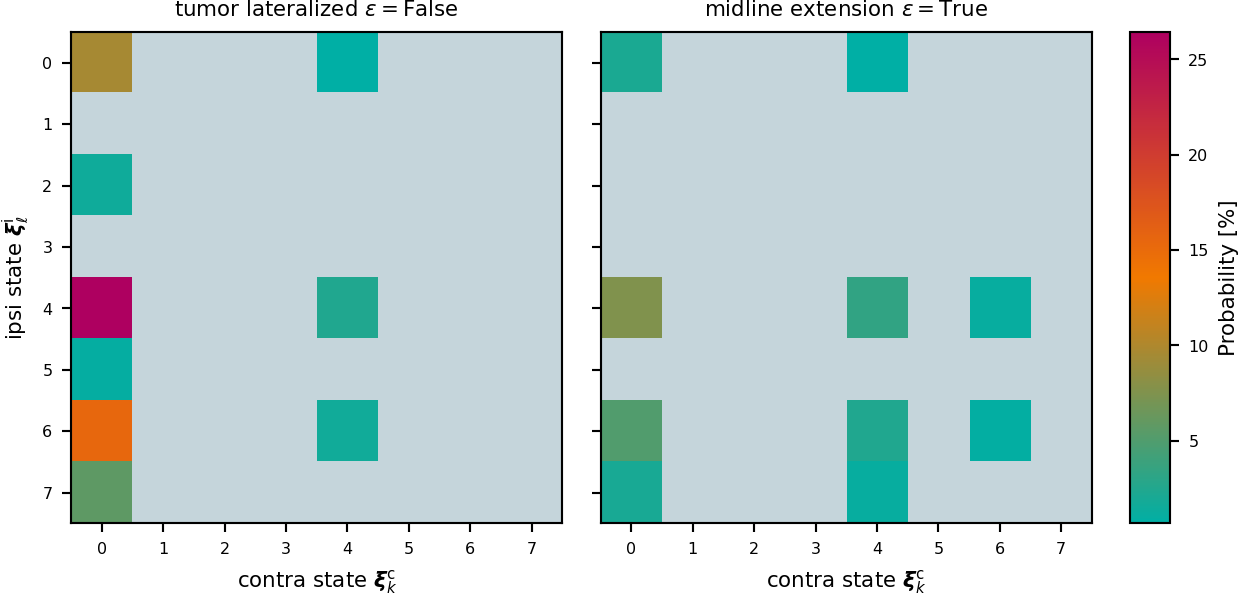

In [3]:
#| label: fig-model-state-dist
#| fig-cap: '3D state distribution of a midline model with 3 LNLs (II, III, and IV) in both sides of the neck.'
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid
from lyscripts.plot.utils import COLORS
from scripts import shared, paths

model = shared.get_model(which="simple", load_samples=True)
state_dist = 100 * model.state_dist(t_stage="late")
vmin, vmax = np.min(state_dist), np.max(state_dist)

nrows, ncols = 1, 2
cmap = LinearSegmentedColormap.from_list(
  name="usz",
  colors=[COLORS["green"], COLORS["orange"], COLORS["red"]],
)
cmap.set_under(COLORS["gray"])

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=1.,
  width=17,
))

fig = plt.figure()
grid = AxesGrid(
  fig, 111,
  nrows_ncols=(nrows, ncols),
  axes_pad=0.2,
  share_all=True,
  cbar_location="right",
  cbar_mode="single",
  cbar_size="8%"
)
noext, midext = grid

im = noext.imshow(state_dist[0], cmap=cmap, vmin=100 * np.exp(-5), vmax=vmax)
im = midext.imshow(state_dist[1], cmap=cmap, vmin=100 * np.exp(-5), vmax=vmax)
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].set_ylabel("Probability [%]")

noext.set_title(r"tumor lateralized $\epsilon=\text{False}$")
midext.set_title(r"midline extension $\epsilon=\text{True}$")

noext.set_ylabel(r"ipsi state $\boldsymbol{\xi}^\text{i}_\ell$")
noext.set_xlabel(r"contra state $\boldsymbol{\xi}^\text{c}_k$")
midext.set_xlabel(r"contra state $\boldsymbol{\xi}^\text{c}_k$")

plt.savefig(paths.figure_dir / "fig-model-state-dist.png", dpi=400)
plt.show()

# Observed vs Predicted Prevalence

To verify that the model does what it is supposed to, we compare how often some selected diagnoses appear in the data and how often the model predicts these diagnoses to be observed.

## Contralteral LNLs II, III, and IV Dependent on T-Cat. and Mid. Ext.

We start witht the most commonly involved LNLs in the contralateral neck: II, III, and IV. We investigate their prevalence in the four scenarios early T-cat. withour mid. ext, late T-cat. without mid. ext., early T-cat. with mid. ext., and late T-cat. with mid. ext.

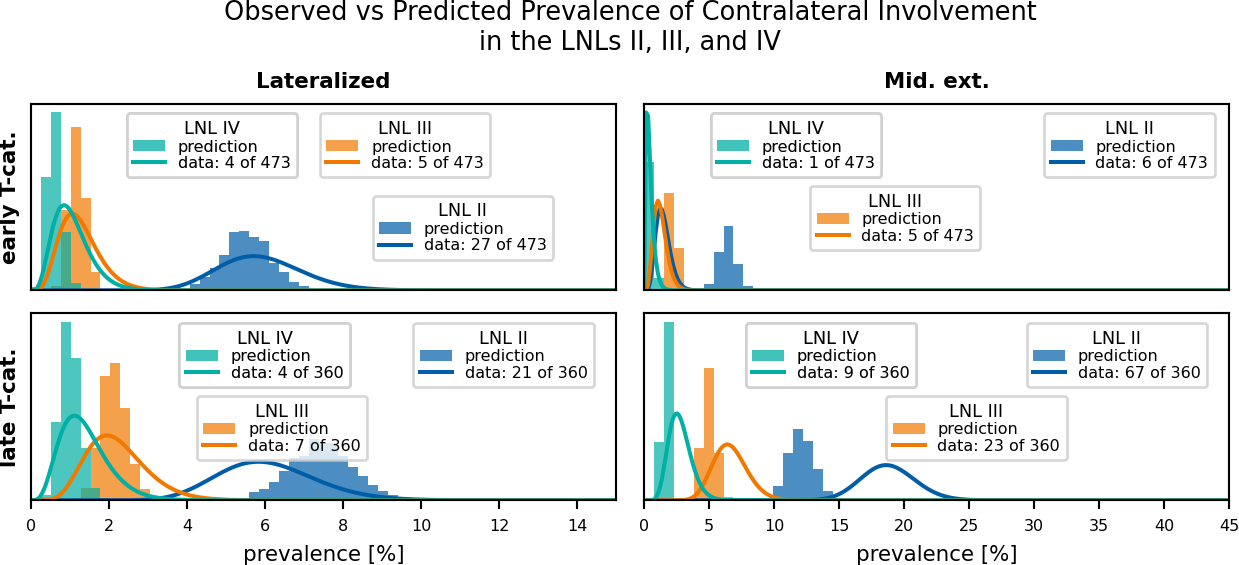

In [4]:
#| label: fig-model-prevalences-overall
#| fig-cap: 'Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown for the contralateral LNLs II (blue), III (orange), and IV (green). The top row shows scenarios with early T-category tumors, the bottom row for late T-category ones. The left column depicts scenarios where the primary tumor is clearly lateralized, the right column scenarios of tumors extending over the mid-sagittal line. This figure illustrates the model''s ability to describe the prevalence of different combinations of scenarios involving the risk factors T-category and midline extension.'
from matplotlib import gridspec
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS
from scripts import paths, shared

def turn_axis_off(axes):
  axes.set_xticks([])
  axes.set_yticks([])

nrows, ncols = 2, 2

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=2.,
  width=17,
))

fig = plt.figure()
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)
axes = np.array([[fig.add_subplot(gs[i,j]) for j in range(ncols)] for i in range(nrows)])
full = fig.add_subplot(gs[:,:], frame_on=False)
turn_axis_off(full)

full.set_title(
  "Observed vs Predicted Prevalence of Contralateral Involvement\nin the LNLs II, III, and IV",
  pad=20.,
  fontsize="large",
)

for i, t_stage in enumerate(["early", "late"]):
  axes[i,0].set_ylabel(f"{t_stage} T-cat.", fontweight="bold")
  for j, midext in enumerate([False, True]):
    axes[0,j].set_title("Mid. ext." if midext else "Lateralized", fontweight="bold")
    axes[0,j].set_xticks([])
    axes[-1,j].set_xlabel("prevalence [%]")
    axes[i,j].set_yticks([])
    content = []
    for lnl, color in zip(
      ["II", "III", "IV"],
      [COLORS["blue"], COLORS["orange"], COLORS["green"]],
    ):
      scenario = Scenario(
        t_stages=[t_stage],
        midext=midext,
        diagnosis={"contra": {"max_llh": {lnl: True}}}
      )
      content.append(
        Histogram.from_hdf5(
          filename=paths.model_dir / "full" / "prevalences_overall.hdf5",
          dataname=scenario.md5_hash("prevalences"),
          color=color,
          label="prediction",
        )
      )
      beta_post = BetaPosterior.from_hdf5(
        filename=paths.model_dir / "full" / "prevalences_overall.hdf5",
        dataname=scenario.md5_hash("prevalences"),
        color=color,
      )
      beta_post.kwargs["label"] = f"data: {beta_post.num_success} of {beta_post.num_total}"
      content.append(beta_post)
    draw(
      axes=axes[i,j],
      contents=content,
      xlims=(0., 15. if not midext else 45.),
    )

# manually place legends
shared.split_legends(
  ax=axes[0,0],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.57, 0.55), (0.48, 0.99), (0.15, 0.99)],
)
shared.split_legends(
  ax=axes[0,1],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.67, 0.99), (0.27, 0.6), (0.1, 0.99)],
)
shared.split_legends(
  ax=axes[1,0],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.64, 0.99), (0.27, 0.6), (0.24, 0.99)],
)
shared.split_legends(
  ax=axes[1,1],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.64, 0.99), (0.4, 0.6), (0.16, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-overall.png", dpi=400)
plt.show()

## Correlation between Ipsi- and Contralateral Involvement

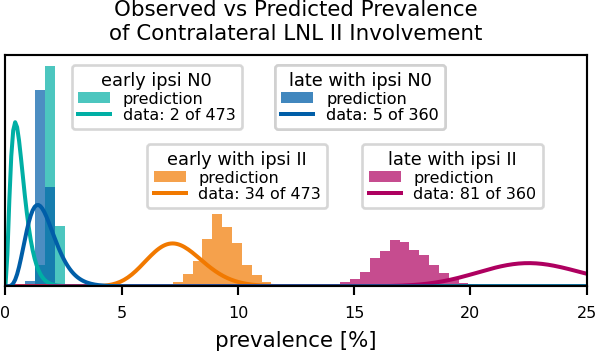

In [5]:
#| label: fig-model-prevalences-with-ipsi
#| fig-cap: 'Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown are four scenarios, all including contralateral LNL II involvement: Early T-category and an ipsilateral N0 neck (green), early T-category and ipsilateral LNL II involvement (blue), as well as the same two scenarios but for advanced T-category (orange and red). The figure shows that the model is capable of describing the correlation between ipsi- and contralateral involvement. Although for the scenario of LNL II involvement in both sides, the prediction''s split between early and advanced T-category is not large enough.'
import matplotlib.pyplot as plt
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS
from scripts import paths, shared

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(width=17./2.))

fig, ax = plt.subplots()
content = []
colors = iter([COLORS[c] for c in ["orange", "green", "red", "blue"]])

for t_stage in ["early", "late"]:
  for diagnosis in [{"II": True}, {lnl: False for lnl in ["I", "II", "III", "IV", "V"]}]:
    color = next(colors)
    scenario = Scenario(
      t_stages=[t_stage],
      diagnosis={
        "ipsi": {"max_llh": diagnosis},
        "contra": {"max_llh": {"II": True}},
      }
    )
    content.append(
      Histogram.from_hdf5(
        filename=paths.model_dir / "full" / "prevalences_with_ipsi.hdf5",
        dataname=scenario.md5_hash("prevalences"),
        color=color,
        label="prediction"
      )
    )
    beta_post = BetaPosterior.from_hdf5(
      filename=paths.model_dir / "full" / "prevalences_with_ipsi.hdf5",
      dataname=scenario.md5_hash("prevalences"),
      color=color,
    )
    beta_post.kwargs["label"] = f"data: {beta_post.num_success} of {beta_post.num_total}"
    content.append(beta_post)

draw(ax, content, xlims=(0., 25.))
ax.set_title("Observed vs Predicted Prevalence\nof Contralateral LNL II Involvement")
ax.set_yticks([])
ax.set_xlabel("prevalence [%]")

shared.split_legends(
  ax=ax,
  titles=["early with ipsi II", "early ipsi N0", "late with ipsi II", "late with ipsi N0"],
  locs=[(0.23, 0.65), (0.1, 0.99), (0.6, 0.65), (0.45, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-with-ipsi.png", dpi=400)
plt.show()

## Portion of Midline Extension

Since we model the tumor’s midline extension as a random variable we can predict its portion among early or late T-category patients and compare it with the observed prevalence in the data.

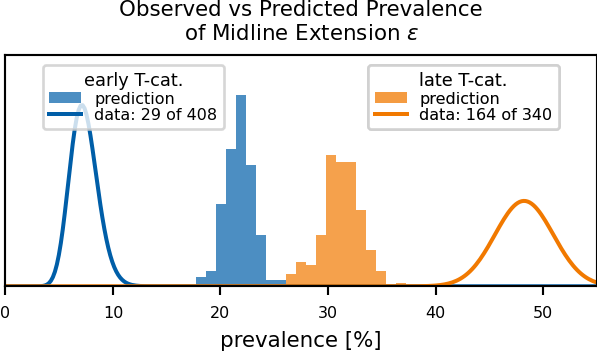

In [6]:
#| label: fig-model-prevalences-midext
#| fig-cap: 'Comparing the predicted (histograms) and observed (lines depicting beta posteriors) prevalence of midline extension for early (blue) and late (orange) T-category. While the prevalence is predicted correctly when marginalizing over T-category, the model cannot capture the degree of separation observed in the data. Since the tumor''s midline extension is virtually always part of the diagnosis and hence *given* when predicting a patient''s risk, we do not consider this discrepancy a major issue.'
import matplotlib.pyplot as plt
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS
from scripts import paths, shared

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(width=17./2.))

fig, ax = plt.subplots()
content = []
colors = iter([COLORS[c] for c in ["blue", "orange"]])

for t_stage in ["early", "late"]:
  color = next(colors)
  content.append(
    Histogram.from_hdf5(
      filename=paths.model_dir / "full" / "prevalences_midext.hdf5",
      dataname=t_stage,
      color=color,
      label="prediction"
    )
  )
  beta_post = BetaPosterior.from_hdf5(
    filename=paths.model_dir / "full" / "prevalences_midext.hdf5",
    dataname=t_stage,
    color=color,
  )
  beta_post.kwargs["label"] = f"data: {beta_post.num_success} of {beta_post.num_total}"
  content.append(beta_post)

draw(ax, content, xlims=(0., 55.))
ax.set_title("Observed vs Predicted Prevalence\nof Midline Extension $\epsilon$")
ax.set_yticks([])
ax.set_ylim(top=0.4)
ax.set_xlabel("prevalence [%]")

shared.split_legends(
  ax=ax,
  titles=["early T-cat.", "late T-cat."],
  locs=[(0.05, 0.99), (0.6, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-midext.png", dpi=400)
plt.show()